![logo.png](https://raw.githubusercontent.com/TienTienYeh/lg-tdgl/main/docs/logo.png)

# Structured light induced vorticity in superconductors

`LG-TDGL` provides a platform to explore the interaction between structured light and superconducting order parameters, enabling the realization of the *quantum printing* effect. The computation of order parameters is based on the framework of the generalized time-depdendent Ginzburg-Landau (TDGL) equation implemented in `pyTDGL` (see reference [1]). <br>
This script, `LG-TDGL`, builds upon the series of works titled ''*Structured light induced vorticity in superconductors*'' (see references [2],[3]). <br>
In this notebook, we showcase an example of a dynamics of superconducting vortices induced by Laguerre-Gaussian beam, and demonstrate the results for the light-imprinted superflow in reference [4].<br>
<br>

The inputs to the Laguerre-Gaussian beam are: (Eqs. (3),(4) of reference [3])<br>
1. Quantum numbers $s$, $l$, $p$.
2. Polarization $\psi_{xy}$ and the temporal phase $\psi_{xy}$ at $t=0$.
3. Amplitide of electric field $E_0$ and size of spot $w_0$.

The inputs to the TDGL model are: (`pyTDGL` in reference [1])<br>
1. Properties of the superconducting at temperature $T<T_c$:  coherence length $\xi(T)$, London penetration depth $\lambda_L(T)$, Strength of inelastic scattering $\gamma$, etc.
2. The geometry of the superconducting film: thickness $d$, width $L_{width}$, height $L_{height}$.
3. The time-dependent vector potential $\mathbf{A}$ from the Laguerre-Gaussian beam.

The outputs of the TDGL model are: (`pyTDGL` in reference [1])<br>
1. The dimentionless complex order parameter $\psi(\mathbf{r},t)=|\psi|e^{i\theta_s}$
2. Sheet current density $J \cdot d$ and electric scalar potential $\mu$.

***
References:<br>
[1] This code requires the `pyTDGL` environment. See the documentation: https://py-tdgl.readthedocs.io/en/latest/, and publication DOI: https://doi.org/10.1016/j.cpc.2023.108799. <br>
[2] ''*Structured light and induced vorticity in superconductors I: Linearly polarized light.*'' DOI: https://arxiv.org/abs/2407.15834. <br>
[3] ''*Structured light and induced vorticity in superconductors II: Quantum Print with Laguerre-Gaussian beam.*'' DOI: https://arxiv.org/abs/2412.00935. <br>
[4] The demonstration corresponds to Fig. 3(d) in reference [2].


In [4]:
# Automatically install tdgl from GitHub only if running in Google Colab
if "google.colab" in str(get_ipython()):
    %pip install --quiet git+https://github.com/loganbvh/py-tdgl.git
    %pip install --quiet git+https://github.com/TienTienYeh/lg-tdgl.git
    !apt install ffmpeg


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.7 MB/s eta 0:00:00
  

In [5]:
# import light_sources.gaussian_beam as gb
import light_sources.laguerre_gaussian_beam as lg
import numpy as np
import tdgl
import os
from matplotlib import pyplot as plt

## 1. Parameter input

**Parameter inputs for superconducting thin film and Laguerre-Gaussian beam:** <br>

**Parameter instruction**:
* Quantum numbers: *p*, *l*, *s*,
* The length of sample: *L*. Here, we consider the square superconduction film *width*=*height*=*L*.
* The amplitude of electric field: `E0`, which is equivalent to $E_0$ in the manuscript [[2]](https://arxiv.org/abs/2407.15834)[[3]](https://arxiv.org/abs/2412.00935).

The parameters below are specific to Fig. 3(d) in reference [2], where the mode of Laguerre-Gaussian beam is LG$_{01,-1}$ ([$p$,$l$,$s$]=[0,1,-1].)<br>
Users can modify these inputs via command lines to simulate different scenarios. For additional parameter sets and general cases, please refer to **Appendix B** of [reference [2]](https://arxiv.org/abs/2407.15834).<br>


In [6]:
### Parameters of setting
p, l, s, L, E_amp = 0, 1, -1, 25, 2 # Parameters of Fig.3(d) in ref [3].
p, l, s, L, E_amp = 0, 1, -1, 10, 40 # Parameters of Fig.3(d) in ref [3].

### Other examples
# p, l, s, L, E0 = 0, 0, 0, 2.5, 0.6 # Parameters of Fig.3(a) in ref [3].
# p, l, s, L, E0 = 0, 0, 1, 2.5, 0.6 # Parameters of Fig.3(b) in ref [3].
# p, l, s, L, E0 = 0, 1, 0, 2.5, 0.9 # Parameters of Fig.3(c) in ref [3].
# p, l, s, L, E0 = 0, 1, 1, 2.5, 1.2 # Parameters of Fig.3(e) in ref [3].


**General settings for all parameters.** The `pyTDGL` package solves the dimentionless TDGL model, where the units of time and length are determined by the parameters of superconductor, $\xi(T)$ and $\tau_{GL}(T)$, respectively. Consequently, the value of speed of light, $c$, changes depending on the system's unit scale. This variation affects the relationships between the wavelength, frequency, wavenumber, and period of light. To address this, we use the function `input_value` to manage the parameters connecting the properties of the superconducting thin film and the Laguerre-Gaussian beam. <br>
The object, `P`, of inputs for settings using `class input_value(**kwargs)`. <br>
> - **Parameters of units** (<span style='color:green'>str</span>):
                 `length_units`: Unit of length,
                 `time_units`: Unit of time,
                 `current_units`: Unit of electric current,
                 `mass_units`: Unit of mass,
                 `angular_freq_units`: Unit of angular frequency,
                 `field_units`: Unit of magnetic field,
                 `E_field_units`: Unit of electric field,
                 `resistivity_units`: Unit of electrical resistivity. <br>
> - **Parameters of superconductors** (<span style='color:green'>float</span>):
                `xi`: Coherent length,
                `london_lambda`: London penetration depth,
                `gamma`: Strength of inelastic scattering,
                `u`: Time ratio of order parameter relaxation,
                `height`: Height of SC film,
                `width`: Width of SC film,
                `thickness`: Thickness of SC film,
                `temperature`: Temperature of SC (Unit of $T_c$),
                `resistivity`: Resistivity of normal state. <br>
> - **Properties of Laguerre-Gaussian (LG) beam** (<span style='color:green'>float</span>):
                `E0`: Input amplitude of electric field (unit:$A_0\omega_{EM}$),
                `w_EM`: Angular frequency of light (choose one of "w_EM" "f_EM" for input, w_EM>=0),
                `f_EM`: Frequency of light (choose one of "w_EM" "f_EM" for input, "f_EM">=0),
                `w_0`: Radius of spot of LG beam,
                `xc_Gauss`: Center position of LG beam,
                `yc_Gauss`: Center position of LG beam,
                `phi0_t`: Inital phase of time (i.e. $\omega_{EM} \cdot t+\phi_{t=0}$),
                `phi0_xy`: Ａngle of polarization (e.g. 0:$x$-polarization and $\pi$/2:$y$-polarization),
                `light_source_type`(<span style='color:green'>str</span>): Setting of light source (autometically setting with keywords "linear_x", "linear_y", "x" , or "y"),
                `p`(<span style='color:green'>int</span>): Quantum number of radial order: $p$,
                `l`(<span style='color:green'>int</span>): Quantum number of orbital angular momentum: $l$,
                `s`(<span style='color:green'>int</span>): Quantum number of spin angular momentum: $s$. <br>
> - **Setting for simulation**:
                `solve_time`(<span style='color:green'>float</span>): Total solving time (Unit: tau_GL),
                `screenSet`(<span style='color:green'>bool</span>): Setting of screening effect,
                `constant_Bz`(<span style='color:green'>float</span>): Constant applied magnetic field. <br>
> - **Setting for demonstration**:
                `quiver_mesh_n`(<span style='color:green'>int</span>): mesh number,
                `quiver_scale`(<span style='color:green'>float</span>): (For quiver plot of $E$) quier scale,
                `width_quiver`(<span style='color:green'>float</span>): (For quiver plot of $E$) quiver width,
                `dpi`(<span style='color:green'>int </span>): DPI of figure. <br>

In [7]:
### Initialize parameters

if s==0: PolType = 'l_x'
if s==1: PolType = 'c_l'
if s==-1: PolType = 'c_r'
xi = 0.1

P = lg.input_value(

    # Unit in the system

    length_units = "um", # SI: m
    time_units = 'ps', # SI: s
    current_units = "mA", # SI: A
    mass_units = 'kg', # SI: kg
    angular_freq_units = 'THz', # SI: 1/s # for demonstration
    field_units = "mT", # SI: kg/s^2/A
    E_field_units = "kvolt/meter", # newton per coulomb (N/C), or volt per meter (V/m), SI: kg*m^2/s^3/A
    resistivity_units = 'ohm * cm',

    # Properties of SC

    xi = xi, # Coherent length
    london_lambda = 0.1, # London penetration depth
    gamma = 10, # Strength of inelastic scattering
    height = L*xi, # Height of sample
    width = L*xi, # Width of sample
    thickness = 2/1000, # Thickness of sample
    temperature = 0.99, # Temperature, Unit of Tc
    resistivity = 150e-6, # Conductivity of normal state

    # Properties of linearly polarized Gaussian beam

    E_amp = E_amp, # Input amplitude of electric field (unit:A0*w_GL)
    w_EM = 2*np.pi / 10, # Angular frequency of light (unit:w_GL)
    w_0 = 0.4, # Radius of spot of Gaussian beam
    xc_Gauss = 0, # Center position of Gaussian beam
    yc_Gauss = 0, # Center position of Gaussian beam
    light_source_type = 'LG'+str(int(p))+str(int(l))+'_'+PolType, # Setting of light source by keyword.
    # ''' Options of light_source_type:
    # "None", "LGpl_l_x" (linearly polarized beam along x of mode LGpl), "LGpl_l_y" (linearly polarized beam along y of mode LGpl),
    # "LGpl_c_l" (left-handed circularly polarized beam of mode LGpl), "LGpl_c_r" (right-handed circularly polarized beam of mode LGpl),
    #  ***If the variable light_source_type is "None":
    #     We need to imput the specific conditions of quantum numbers and polarization.
    #     Default: p=0 (int), l=0 (int), s=0 (float or int), phi0_xy=0 (float or int)
    #     Reference of quantum numbers and polarization: TABLE I in ref[3].
    # '''

    # Settings of running simulation

    screenSet = False, # Setting of screening effect
    solve_time = 1, # Total solving time (Unit: tau_GL)

    # Settings of figures

    quiver_mesh_n = 30, # Plot of E (quiver): mesh number
    quiver_scale = 0.05, # Plot of E (quiver): quier scale
    width_quiver = 0.1, # Plot of E (quiver): quiver width
    dpi = 100, # Dpi of figure
)

''' Done. '''

/usr/local/lib/python3.10/dist-packages/pint/facets/plain/quantity.py:998: RuntimeWarning: invalid value encountered in scalar divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


' Done. '

## Confirmation of the input parameters
Set the option to demonstrate the profiles of the Laguerre-Gaussian beam and parameters of superconductor.

In [8]:
preview_show = True

### Preview of parameters of superconducting film

The `P.print_properties` function displays the input parameters and system dimensions. To use this function, provide the desired parameter keyword(s) as strings, separated by commas (,). The keywords are case-insensitive (both uppercase and lowercase work). To display all available parameters, use the keyword 'All'.
- The available parameters are the same as the keywords in `input_value` mentioned above.
- The other available parameters about dimention are: 'tau_gl','xi','f_gl','Hc1','Hc2','Bc1','Bc2','A0','J0','E0_GL'.
- You can update these parameters using the `P.set_state` function.



 *** Demonstration of selected parameters:
Conductivity (1/resistivity): 6666.666666666666 / centimeter / ohm
|E0| of light: 15713.652974084864 kilovolt / meter
Quantum number of orbital angular momentum (l): 1
Quantum number of spin angular momentum (s): -1

 *** Demonstration of selected dimentions:
Characteristic timescale (tau_GL): 0.008377580414133334 picosecond
Characteristic rate (1/tau_GL): 119.36620725394143 terahertz
Bc2 of SC (mu0Hc2): 32.91059784754533 millitesla
Unit vector potential A0 (xi*Bc2): 3.2910597847545335 micrometer * millitesla
Unit current density (J0 = 4*xi*Bc2/mu_0/lambdaL**2): 1047.5768649389909 milliampere / micrometer ** 2
Unit of electric field E0_GL (A0*f_GL): 392.8413243521215 micrometer * millitesla / picosecond

 *** TABLE: The parameters of superconductor mentioned in TABLE II in the reference [2].


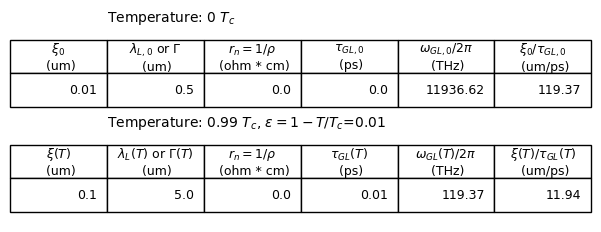

In [9]:
## Print out the inputs. Print the selected parameters, or use "P.print_properties(['All'])" to print all parameters.

if preview_show:

    print('\n *** Demonstration of selected parameters:')
    P.print_properties(['Conductivity','E_amp','s','l'])
    print('\n *** Demonstration of selected dimentions:')
    P.print_properties(['tau_gl','f_gl','Bc2','A0','J0','E0_GL'])
    print('\n *** TABLE: The parameters of superconductor mentioned in TABLE II in the reference [2].')
    TAB = lg.printTAB(P)

## Example of update parameter(s) and check

# P.set_state(E_amp = 8, p=1,)
# P.print_properties(['E0','E_amp','p'])
# P.print_properties(['All'])

### Preview of Laguerre-Gaussian beam

The snapshots of the electric field and magnetic field of the Laguerre-Gaussian beam are shown in the left and right figures below, respectively. The demonstration includes two timeframes: $t \cdot \omega_{EM} = 0$ and $t \cdot \omega_{EM} = \pi/2$, which can be controlled by the parameter `ti`.<br>

**Instructions for the Script:**
* *title_set*: A string displayed in the figure's title.
* *ti*: The input time.
* `E_input_frame`:  This function calculates the electric field components *E_x* and *E_y* a given time *ti*.  The calculation is based on the input parameter `input_value` and the Laguerre-Gaussian beam at the focal point (refer to Eqs. (3),(4) in [reference [3]](https://arxiv.org/abs/2412.00935) ).
> Parameters: `E_input_frame(X,Y,E_x,E_y,B_z,E0i=1.0,title='',figsize=(6, 3),scale=12,dpi=100,take_Bz_range=False,width_quiver=0.01)`<br>
> *ti*: Time for the snapshots, *take_real*: (<span style='color:green'> bool </span>). Outputs the real part if <span style='color:green'> **True** </span>, and conplex number if <span style='color:green'> **False** </span>.
* `E2Bv`: This function calculates the magnetic field from the 2D slice of the electric field *E_x* and *E_y*.
> Parameters: `E2Bv(xv,yv,Ex,Ey,Bz_constant,c,w)`<br>
* `plot_EM`: This function generates a quiver plot of the 2D slice of the electric field *E_x* and *E_y*.
> Parameters: `plot_EM(X,Y,E_x,E_y,B_z,E0i=1.0,title='',figsize=(6, 3),scale=12,dpi=100,take_Bz_range=False,width_quiver=0.01)`<br>


/usr/local/lib/python3.10/dist-packages/light_sources/laguerre_gaussian_beam.py:785: UserWarning: linewidths is ignored by contourf
  contour_Bz = ax2.contourf(Xv, Yv, B_z, levels=50, linewidths=0.0, cmap="PRGn",vmin=Bzmin,vmax=Bzmax)
<ipython-input-10-1c1680f94e2e>:16: RuntimeWarning: invalid value encountered in divide
  lg.plot_EM(P.X,P.Y,np.real(E_x),np.real(E_y),np.real(Phi_B/Phi_B.max()),E0i=P.E_amp,title=title_set,


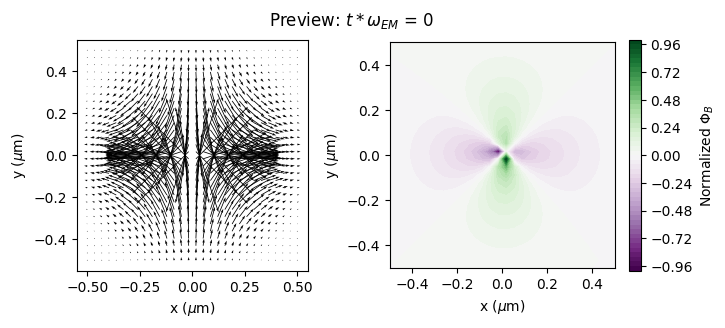

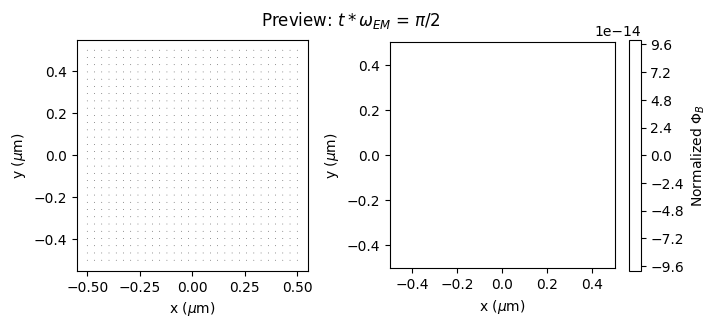

In [10]:
if preview_show:

        title_set = 'Preview: $t*\\omega_{EM}$ = 0'
        ti = 0
        E_x, E_y = P.E_input_frame(ti,take_real=False)
        B_x, B_y, B_z = lg.E2Bv(P.Xv,P.Yv,E_x,E_y,P.constant_Bz,P.c,P.w_EM)
        Phi_B = B_z*np.pi*P.w_0**2
        lg.plot_EM(P.X,P.Y,np.real(E_x),np.real(E_y),np.real(Phi_B/Phi_B.max()),E0i=P.E_amp,title=title_set,
                   figsize=(8,3),scale=P.quiver_scale,dpi=P.dpi,width_quiver=P.width_quiver)

        title_set = 'Preview: $t*\\omega_{EM}$ = $\\pi$/2'
        ti = (2*np.pi/4) / P.w_EM
        E_x, E_y = P.E_input_frame(ti,take_real=False)
        B_x, B_y, B_z = lg.E2Bv(P.Xv,P.Yv,E_x,E_y,P.constant_Bz,P.c,P.w_EM)
        Phi_B = B_z*np.pi*P.w_0**2
        lg.plot_EM(P.X,P.Y,np.real(E_x),np.real(E_y),np.real(Phi_B/Phi_B.max()),E0i=P.E_amp,title=title_set,
                   figsize=(8,3),scale=P.quiver_scale,dpi=P.dpi,width_quiver=P.width_quiver)


## 2. Superconductor (SC) thin film
Generate the meshgrid for a superconducting thin film using the `device` function from the `pyTDGL` package, incorporating the parameters stored in the `P` object. For more details, please refer to reference [1].

**Function indtruction**:

> - `tdgl.Layer`: Defines the superconducting (SC) properties.
> - `tdgl.Polygon`: Defines the geometry of the SC film.
> - `tdgl.Device`: Used for the collection of input setting objects.<br>

**Steps**:
> 1. Generate the Mesh: Use the `device.make_mesh` function to generate the mesh for the SC film based on the provided geometry and layer properties.
> 2. Visualization and print results:
    * Plot the Mesh: Call the `device.plot` function to visualize the generated mesh of the SC film.
    * Mesh Statistics: Use the `device.mesh_stats` function to display information and statistics about the mesh.<br>

Constructing Voronoi polygons: 100%|██████████| 5257/5257 [00:04<00:00, 1115.25it/s]


num_sites,5257
num_elements,10216
min_edge_length,7.625e-03
max_edge_length,2.485e-02
mean_edge_length,1.507e-02
min_area,3.948e-05
max_area,3.898e-04
mean_area,1.902e-04
coherence_length,1.000e-01
length_units,um


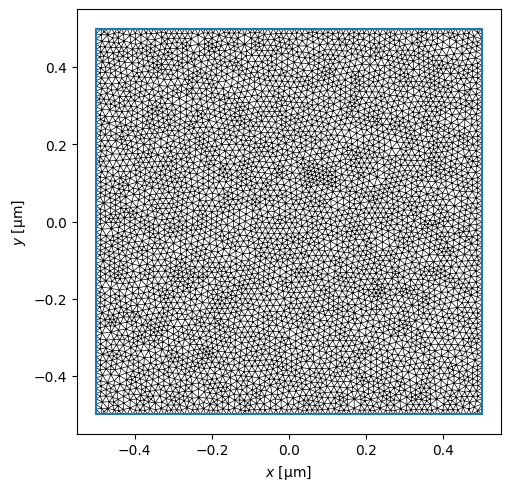

In [11]:
## Generate the mesh by `pyTDGL`

layer = tdgl.Layer(coherence_length=P.xi, london_lambda=P.london_lambda, thickness=P.thickness, gamma=P.gamma, u=P.u, conductivity=P.conductivity)
film = tdgl.Polygon("film", points=tdgl.geometry.box(P.width, P.height, points=301))
device = tdgl.Device("bar", layer=layer, film=film, length_units=P.length_units,)
device.make_mesh(max_edge_length=P.xi / 4, smooth=100)

## Demonstration

fig, ax = device.plot(mesh=True, legend=False)
device.mesh_stats()

## 3. Solve the TDGL model

This section covers the simulation of the TDGL (Time-Dependent Ginzburg-Landau) model with the vector potential of a Laguerre-Gaussian beam.

**Function indtruction**:

> - `lg.A_LG`: This function defines the vector potential of the Laguerre-Gaussian beam.
> - `tdgl.solve`: This function solves for the superconducting order parameter and supercurrent using the TDGL model. For more details, refer to [reference [1]](https://doi.org/10.1016/j.cpc.2023.108799).
> - The results will be saved in a *.h5* file located in a temporary directory generated by the `tempfile` package.
> - GPU Acceleration: The `tdgl.solve` function supports GPU computation. In this demonstration, GPU usage is disabled by setting *Execute_GPU=*<span style='color:green'> **True** </span>.


In [12]:
import tempfile
tempdir = tempfile.TemporaryDirectory()
# tempdir = os.path.join(os.getcwd(),folder_name)
Execute_GPU = False

options = tdgl.SolverOptions(
        solve_time=P.solve_time,
        field_units=P.field_units,
        current_units=P.current_units,
        include_screening=P.screenSet,
        max_iterations_per_step=200000,
        save_every=100,
        dt_max=1e-3,
        output_file=os.path.join(os.getcwd(), "SC_solution.h5"),
        gpu=Execute_GPU,
    )


### Solve device

applied_vector_potential = lg.A_LG(w=P.w_EM, w0=P.w_0, E0=P.E0i, phi0_t=P.phi0_t, phi0_xy=P.phi0_xy, c=P.c, tau=P.tau_GL,
                                p=P.p,s=P.s,l=P.l, polarization_modulation=P.polarization_modulation, xc_Gauss=P.xc_Gauss, yc_Gauss=P.yc_Gauss, t_off=P.t_off,
                                angular_freq_units=P.angular_freq_units, length_units=P.length_units, E_field_units=P.E_field_units, time_units=P.time_units,)
SC_solution = tdgl.solve(device, options, applied_vector_potential=applied_vector_potential,disorder_epsilon=P.disorder_epsilon)

''' Done.'''

Simulating: 100%|█████████▉| 1/1 [00:25<00:00, 25.38s/tau ]


' Done.'

## 4. Demonstration of simulation results:

**Snapshots of order parameters, induced current, and EM wave.**

Snapshots of the simulation results are taken at specified timeframes determined by the input parameter *tn_set* (Unit: $\tau_{GL}$).  If the specified time exceeds the total solving time (*P.solve_time*), the last available snapshot will be displayed.

/usr/local/lib/python3.10/dist-packages/light_sources/laguerre_gaussian_beam.py:785: UserWarning: linewidths is ignored by contourf
  contour_Bz = ax2.contourf(Xv, Yv, B_z, levels=50, linewidths=0.0, cmap="PRGn",vmin=Bzmin,vmax=Bzmax)


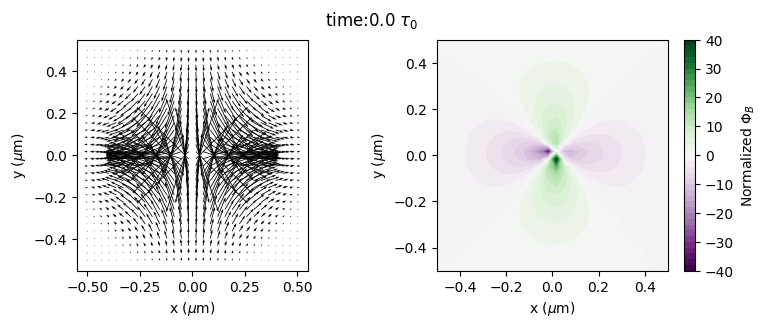

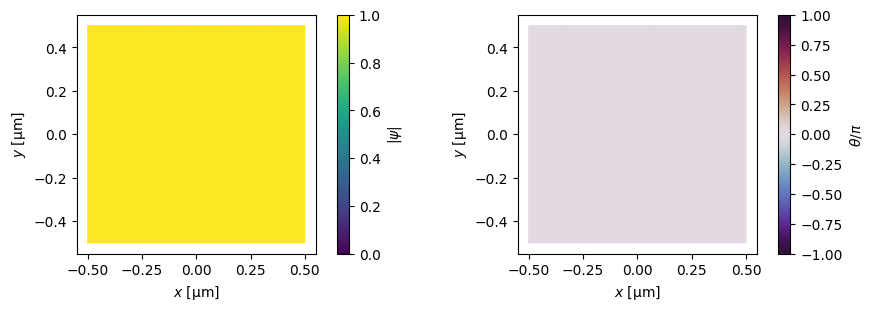

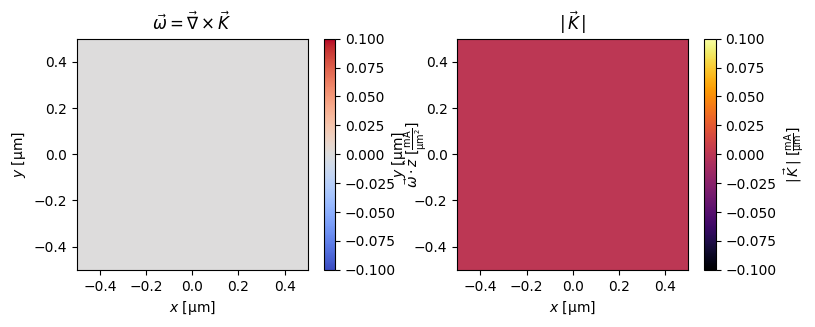

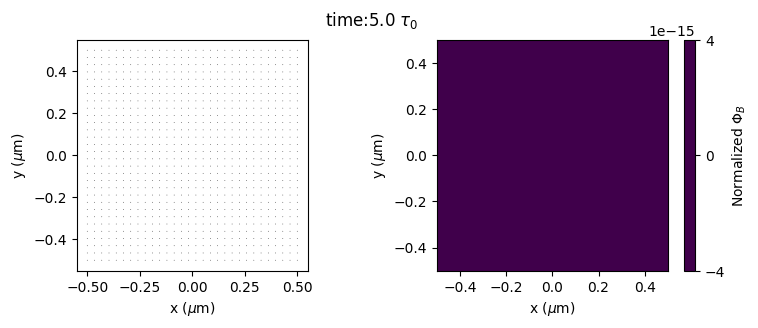

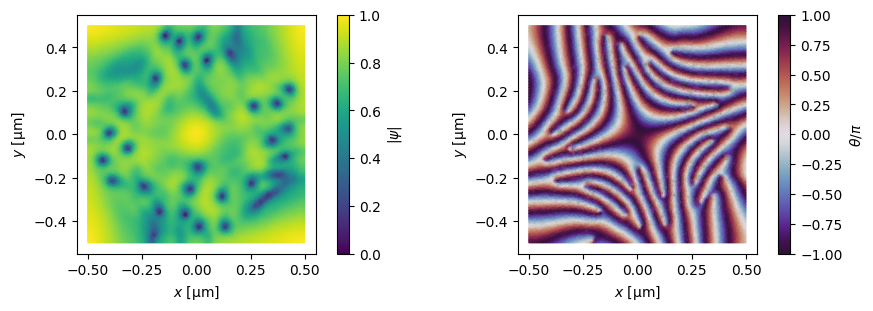

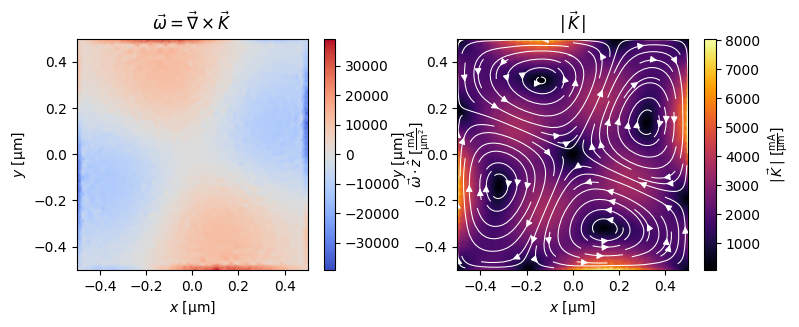

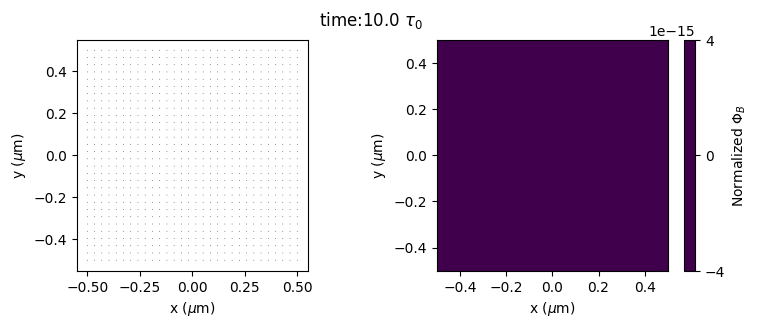

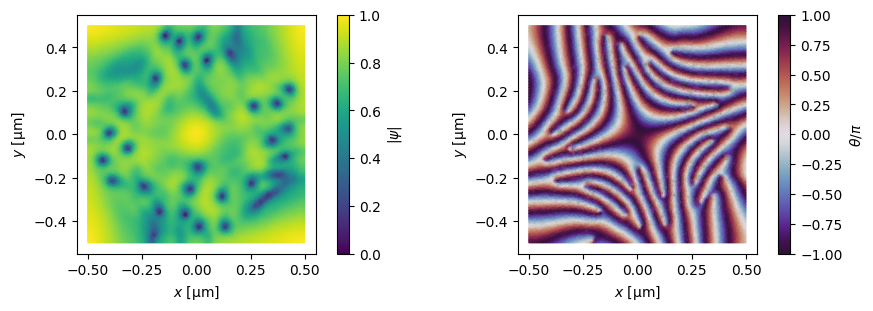

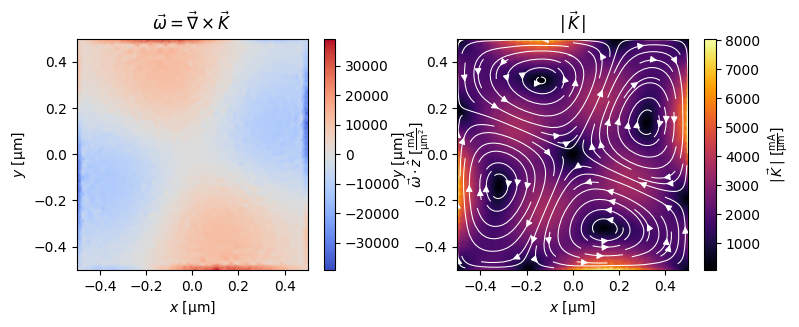

In [13]:
### Demonstrate the electrical field, order parameter, vorticity, at time in tn_set

tn_set = [0, 5, 10] # Unit of tau_GL


for nt in range(len(tn_set)):
    ti = tn_set[nt]

 ## Figures of Electric field and out-of-plan magnetic field:
    title_set = 'time:'+str(int(ti*100)/100)+' $\\tau_0$'
    E_x, E_y = P.E_input_frame(ti,take_real=False)
    B_x, B_y, B_z = lg.E2Bv(P.Xv,P.Yv,E_x,E_y,0,P.c,P.w_EM)
    lg.plot_EM(P.X,P.Y,np.real(E_x),np.real(E_y),np.real(B_z),E0i=P.E0i,title=title_set,figsize=(9,3),scale=P.quiver_scale,dpi=P.dpi,width_quiver=P.width_quiver)

 ## Figures of amplitude and phase of SC order parameter:
    SC_solution.solve_step = SC_solution.closest_solve_step(ti)
    fig, axes = SC_solution.plot_order_parameter(figsize=(9, 3),dpi=P.dpi)

 ## Figures of vorticity of induced current and current density:
    fig, axes = plt.subplots(1, 2, figsize=(9, 3),dpi=P.dpi)
    _ = SC_solution.plot_vorticity(ax=axes[0]) #, streamplot=False
    _ = SC_solution.plot_currents(ax=axes[1]) #, streamplot=False


**Video of simulation results**

We can create anumations of time dependent simulation resluts of supercondicting parameters and electromagnetic wave. This script produce animations of order parameter, vorticity, electric field, and out-of-plane magnetic field.



In [14]:
from light_sources.make_video import make_video_from_solution

MAKE_ANIMATIONS = True

if MAKE_ANIMATIONS:
        output_video = make_video_from_solution(
            SC_solution,
            P,
            quantities=["order_parameter","phase","vorticity"],
            figsize=(18, 4),
            fps=20,
            dpi=P.dpi,
            quiver_scale=P.quiver_scale,
            quiver_mesh_n=P.quiver_mesh_n,
        )
        display(output_video)